In [284]:
import numpy as np
import os
import pandas as pd
from graphviz import Digraph
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [285]:
class node:
    
    # Initialize
    def __init__(self):
        self.right = None
        self.left = None
        self.condition = None
        self.col = None
        self.val = None
        self.gini = None
        self.parent = None
        self.key = None
        self.target = None
        self.target_values = None
        
    # Get the condition string from any node
    def get_condition_str(self):
        return(str(self.col) + "<=" + str(self.val))
    
    def has_parent(self):
        if self.parent!=None:
            return(True)
        else:
            return(False)
        
    def has_left(self):
        if self.left!=None:
            return(True)
        else:
            return(False)
        
    def has_right(self):
        if self.right!=None:
            return(True)
        else:
            return(False)
    
    def has_child(self):
        if (self.right!=None) and self.left!=None:
            return(True)
        else:
            return(False)

In [286]:
class DecisionTree():
    
    def __init__(self, min_samples_split=5, max_depth=10, min_samples_leaf=5):
        self.head = None
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
    
    # Get the data at the current node based its position in the tree
    def get_data(self, curr, data, Y_col):
        cols = data.drop(Y_col, axis=1).columns.tolist()
        while curr != self.head:
            par = curr.parent
            if par.left == curr:
                data = data.loc[data[par.col]<=par.val]
                cols.remove(par.col)
            else:
                data = data.loc[data[par.col]>par.val]
                cols.remove(par.col)
            curr = par
            par = par.parent
            if data.shape[0]<self.min_samples_split:
                return(pd.DataFrame(), [])
        return(data, cols)
    
    # Gini impurity
    def Gini_value_cont(self, data, Y, cols):
        gini_arr = []
        for col in cols:
            val_list = sorted(data[col].unique().tolist())
            midpoints = []
            for i in range(len(val_list)-1):
                midpoints.append(np.mean([val_list[i], val_list[i+1]]))
            for val in midpoints:
                split = col + ": " + "<= " + str(val)
                left = data.loc[data[col]<=val,Y]
                left_prob = left.value_counts()/left.shape[0]
                gini_left = 1 - np.sum(np.power(np.array(left_prob),2))

                right = data.loc[data[col]>val,Y]
                right_prob = right.value_counts()/right.shape[0]
                gini_right = 1 - np.sum(np.power(np.array(right_prob),2))


                val_cnts = []
                val_cnts.append(data.loc[data[col]<=val,col].shape[0]/data.shape[0])
                val_cnts.append(data.loc[data[col]>val,col].shape[0]/data.shape[0])
                weighted_gini = np.sum(np.array([gini_left, gini_right])*np.array(val_cnts))
                gini_arr.append([split, col, val, weighted_gini])
        return(np.array(gini_arr))
    
    # Get column with minimum Gini impurity value
    def get_min_gini_condition(self, gini_arr):
        return(gini_arr[np.where(gini_arr[:,3]==min(gini_arr[:,3]))][0])
    
    # Fit the model
    def fit(self, dataset, target):
        Y_col = target
        self.head = node()
        queue = [] # Use a queue for breadth first traversal
        queue.append(self.head)
        i = 0
        while(len(queue)!=0):
            i += 1
            curr = queue.pop(0)
            data, cols = self.get_data(curr, dataset, Y_col)

            if data.shape[0]==0:
                continue

            gini_arr = self.Gini_value_cont(data, Y_col, cols)
            if len(gini_arr) == 0:
                continue
            min_gini_condition = self.get_min_gini_condition(gini_arr)

            curr.condition = min_gini_condition[0]
            curr.col = min_gini_condition[1]
            curr.val = float(min_gini_condition[2])
            curr.gini = float(min_gini_condition[3])
            curr.key = curr.col
            curr.target = data[Y_col].value_counts().idxmax()
            curr.target_values = data[Y_col].value_counts().tolist()

            if len(cols)>1:
                new_node= node()
                curr.left = new_node
                new_node.parent = curr
                queue.append(new_node)
                new_node= node()
                curr.right = new_node
                new_node.parent = curr
                queue.append(new_node)
    
    def predict(self, test):
        pred = []
        loc = self.head
        for ind, row in test.iterrows():
            depth = 0
            while (loc.has_child() and depth<=self.max_depth):
                if row[loc.col] <= loc.val:
                    loc = loc.left
                    depth +=1
                elif row[loc.col] > loc.val:
                    loc = loc.right
                    depth +=1
                if (loc.col==None) or (sum(loc.target_values)<=self.min_samples_leaf):
                    loc = loc.parent
                    break
            pred.append(loc.target)
            loc = self.head
        return(pred)
    
    def visualize(self, dot=None):
        dot = self.add_nodes(self.head)
        return(dot)

    def add_nodes(self, node, dot=None):
        fontsize = "6.5"
        col = "black"
        if dot is None:
            dot = Digraph()
            if(node.col!=None):
                label_content = str(node.get_condition_str()) + "\n" + "gini=" + str(np.round(node.gini,3)) + "\n" + "samples=" + str(sum(node.target_values))
            else:
                label_content="NULL"
            dot.node(name=str(node), label=label_content, color = col, shape="box", fixedsize="False", width="0.6", fontsize=fontsize)

        if(node.has_left()):
            if(node.left.col!=None):
                label_content = str(node.left.get_condition_str()) + "\n" + "gini=" + str(np.round(node.left.gini,3)) + "\n" + "samples=" + str(sum(node.left.target_values))
            else:
                label_content="NULL"
            dot.node(name=str(node.left), label=label_content, color = col, shape="box", fixedsize="False", width="0.6", fontsize=fontsize)
            dot.edge(str(node), str(node.left))
            dot = self.add_nodes(node.left, dot=dot)

        if(node.has_right()):
            if(node.right.col!=None):
                label_content = str(node.right.get_condition_str()) + "\n" + "gini=" + str(np.round(node.right.gini,3)) + "\n" + "samples=" + str(sum(node.right.target_values))
            else:
                label_content="NULL"
            dot.node(name=str(node.right), label=label_content, color = col, shape="box", fixedsize="False", width="0.6", fontsize=fontsize)
            dot.edge(str(node), str(node.right))
            dot = self.add_nodes(node.right, dot=dot)
        return(dot)
    
    def BFT_array(self):
        q = []
        arr = []
        q.append(self.head)
        arr.append(self.head)

        while(len(q)>0):
            node = q.pop(0)
            if node.left != None:
                q.append(node.left)
                arr.append(node.left)
            if node.right!=None:
                q.append(node.right)
                arr.append(node.right)
        return(arr)

In [287]:

# import dataset
dataset = pd.read_csv("train.csv")

# Data cleaning
dataset['Member'] = dataset['SibSp'] + dataset['Parch']

dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare') 
dataset['Title'] = dataset['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
dataset['Title'] = dataset['Title'].fillna(0)
dataset['Title'] = dataset['Title'].astype(int)

dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} )
dataset['Embarked'] = dataset['Embarked'].fillna('S')
dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

dataset['Age'] = dataset['Age'].fillna(0)
dataset.loc[(dataset['Age'] == 0) & (dataset['Title'] == 1), 'Age'] = 35
dataset.loc[(dataset['Age'] == 0) & (dataset['Title'] == 2), 'Age'] = 23
dataset.loc[(dataset['Age'] == 0) & (dataset['Title'] == 3), 'Age'] = 35
dataset.loc[(dataset['Age'] == 0) & (dataset['Title'] == 4), 'Age'] = 15
dataset.loc[(dataset['Age'] == 0) & (dataset['Title'] == 5), 'Age'] = 40

dataset['AgeBand'] = pd.cut(dataset['Age'], 5)

ageb = list(set(dataset['AgeBand']))
dataset['AgeBandno'] = 0
for i,item in zip(range(1,5), ageb):
    dataset.loc[dataset['Age'].between(item.left, item.right), 'AgeBandno'] = i
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean()) 
dataset['FareBand'] = pd.cut(dataset['Fare'], 5)
fareb = list(set(dataset['FareBand']))
dataset['FareBandno'] = 0

for i,item in zip(range(1,5), fareb):
    dataset.loc[dataset['Fare'].between(item.left, item.right), 'FareBandno'] = i

#dataset = dataset.drop(['PassengerId','Name', 'Ticket', 'Cabin', 'AgeBand', 'FareBand', 'Age', 'Fare'], axis = 1)
full_dataset = dataset.copy()
dataset = dataset[['Title', 'Pclass', 'Sex', 'AgeBandno','Survived']]

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [296]:
# Fit the model
clf = DecisionTree(max_depth=6, min_samples_leaf=10, min_samples_split=5)
Y_col = 'Survived'
clf.fit(train, Y_col)

In [297]:
# Predict the values and find the accuracy
pred = clf.predict(test)
print("Accuracy: ", np.round(accuracy_score(test['Survived'], pred),3))

Accuracy:  0.737


In [298]:
# Compare the accuracy with sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf_sk = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=6, min_samples_leaf=10, min_samples_split=5)
clf_sk.fit(train.drop(Y_col, axis=1), train[Y_col])
sklearn_pred = clf_sk.predict(test.drop('Survived', axis=1))
print("Sklearn Accuracy: ", np.round(accuracy_score(test['Survived'], sklearn_pred),3))

Sklearn Accuracy:  0.749


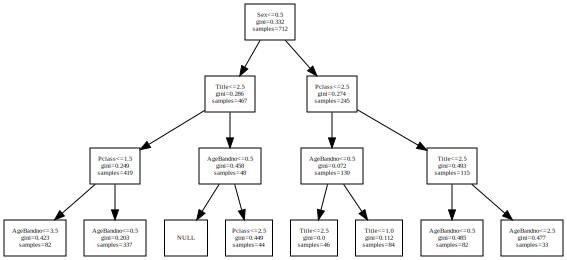

In [299]:
# Visualize the Tree
clf.visualize()

In [300]:
# using the full dataset - Accuracy improves considerable and is comparable with sklearn
dataset = full_dataset.drop(['PassengerId','Name', 'Ticket', 'Cabin', 'AgeBand', 'FareBand', 'Age', 'Fare'], axis = 1)
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
clf = DecisionTree(max_depth=6, min_samples_leaf=10, min_samples_split=5)
Y_col = 'Survived'
clf.fit(train, Y_col)
pred = clf.predict(test)
print("Accuracy from our model: ", np.round(accuracy_score(test['Survived'], pred),3))

clf_sk = DecisionTreeClassifier(max_depth=6, random_state=42, criterion='gini', min_samples_leaf=10,  min_samples_split=5)
clf_sk.fit(train.drop(Y_col, axis=1), train[Y_col])
sklearn_pred = clf_sk.predict(test.drop('Survived', axis=1))
print("Accuracy from sklearn model: ", np.round(accuracy_score(test['Survived'], sklearn_pred),3))

Accuracy from our model:  0.816
Accuracy from sklearn model:  0.816
